In [1]:
# -- IMPORTS --
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import datetime as dt
import os

DATA_DIR = './data'

%matplotlib inline

# Loading Data

In [3]:
def load_data():
    """Load and preprocess csv files. Return data frames.
    """
    pi = pd.read_csv(os.path.join(DATA_DIR, 'clean', 'PatientInfoClean.csv'), 
                     index_col='patient_id')
    # do not set index_col on this df
    pr = pd.read_csv(os.path.join(DATA_DIR, 'clean', 'PatientRouteClean.csv'))
    
    # possible incorrect entries, patient recorded as infected by themselves
    pi.loc[1100000028, 'infected_by'] = np.nan
    pi.loc[1100000028, 'infection_case'] = np.nan
    pi.loc[6100000066, 'infected_by'] = np.nan
    pi.loc[6100000066, 'infection_case'] = np.nan
    
    def convert_dt(column):
        """Helper func to convert column to datetime column.
        """
        return pd.to_datetime(column, format='%Y-%m-%d', errors='ignore')
    
    # convert date columns to datetime formats
    pi['symptom_onset_date'] = convert_dt(pi['symptom_onset_date'])
    pi['confirmed_date'] = convert_dt(pi['confirmed_date'])
    pi['released_date'] = convert_dt(pi['released_date'])
    pi['deceased_date'] = convert_dt(pi['deceased_date'])
    pr['date'] = convert_dt(pr['date'])
    
    # sort routes by date
    pr.sort_values('date', inplace=True)
    pr.reset_index(inplace=True)
    
    return pi, pr

pi, pr = load_data()

## The Data

In [4]:
pi.head()

,sex,age,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
patient_id,,,,,,,,,,,,
1000000001,male,50s,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaT,released
1000000002,male,30s,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaT,released
1000000003,male,50s,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaT,released
1000000004,male,20s,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaT,released
1000000005,female,20s,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaT,released


In [5]:
pr.head()

,index,patient_id,date,province,city,type,latitude,longitude
0,3470,2000000002,2020-01-20,Gyeonggi-do,Pyeongtaek-si,public_transportation,37.079485,127.057749
1,3471,2000000002,2020-01-21,Gyeonggi-do,Pyeongtaek-si,etc,36.992108,127.112945
2,0,1000000001,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632
3,3467,2000000001,2020-01-22,Seoul,Gangnam-gu,hospital,37.524355,127.027948
4,3120,1400000003,2020-01-23,Seoul,Yongsan-gu,etc,37.536606,126.977140


# Patient Info Graph

In [6]:
def grow_infection_graph(pi):
    pi = pi.sort_values('confirmed_date')
    cur_date = pi.iloc[0]['confirmed_date'] # start date
    g = nx.DiGraph()
    daily_patients = []
    
    for idx, patient in pi.iterrows():
        # yield graph back to caller when moving to next time step
        if patient['confirmed_date'] > cur_date:
            cur_date = patient['confirmed_date']
            yield g, daily_patients
            daily_patients = [] # clear patients for next day
        
        # build g
        g.add_node(idx, **dict(patient))
        daily_patients.append(patient)

        if not np.isnan(patient['infected_by']):
            g.add_edge(int(patient['infected_by']), idx)

# SIMULATE GROWTH & TRACK METRICS
patient_progression = []
infection_progression = []
male_cases = []
female_cases = []
for pat_g, daily_patients in grow_infection_graph(pi.copy()):
    patient_progression.append(len(pat_g)) # track nodes
    infection_progression.append(pat_g.size()) # track edges
    
    male_cases.append([p for p in daily_patients if p['sex'] == 'male'])
    female_cases.append([p for p in daily_patients if p['sex'] == 'female'])

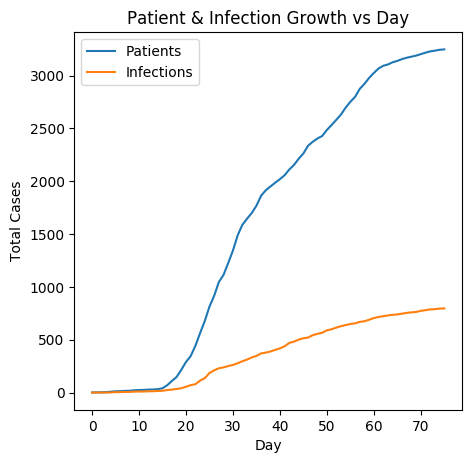

In [8]:
plt.figure(figsize=(5, 5), dpi= 100)
plt.plot(range(len(patient_progression)), patient_progression, label='Patients')
plt.plot(range(len(infection_progression)), infection_progression, label='Infections')
plt.xlabel('Day')
plt.ylabel('Total Cases')
plt.title('Patient & Infection Growth vs Day')        
plt.legend(loc='best')
# plt.savefig('graphs/patient-infection-growth-vs-day', bbox_inches='tight')
plt.show()

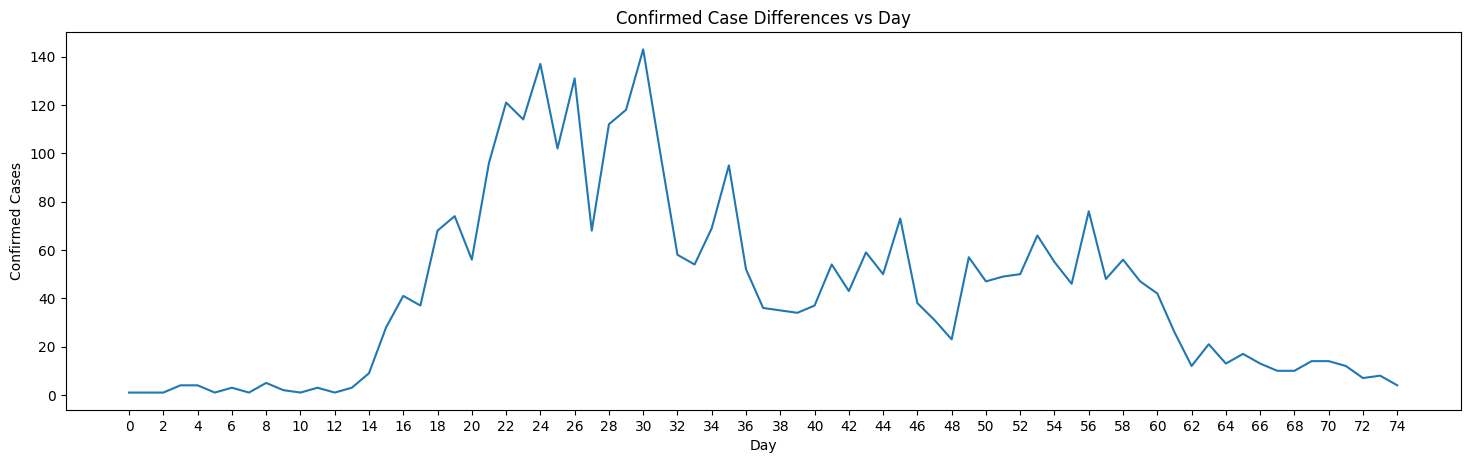

In [9]:
# find differences between successive elements
patient_diffs = [j - i for i, j in zip(patient_progression[:-1], patient_progression[1:])]

plt.figure(figsize=(18, 5), dpi= 100)
plt.plot(range(len(patient_diffs)), patient_diffs)
plt.xlabel('Day')
plt.ylabel('Confirmed Cases')
plt.xticks(range(0, len(patient_progression), 2))
plt.title('Confirmed Case Differences vs Day')
# plt.savefig('graphs/confirmed-case-diff-vs-day')
plt.show()

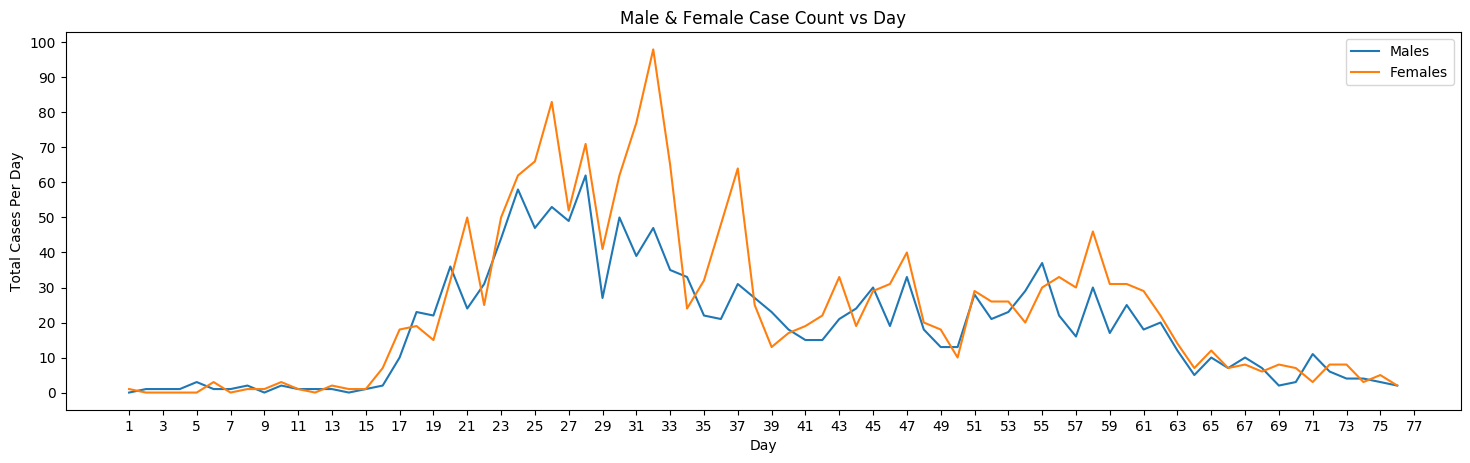

In [10]:
male_case_totals = [len(cases) for cases in male_cases]
female_case_totals = [len(cases) for cases in female_cases]

plt.figure(figsize=(18, 5), dpi= 100)
plt.plot(range(1, len(male_case_totals) + 1), male_case_totals, label='Males')
plt.plot(range(1, len(female_case_totals) + 1), female_case_totals, label='Females')
plt.xlabel('Day')
plt.ylabel('Total Cases Per Day')
plt.xticks(range(1, len(male_case_totals) + 2, 2))
plt.yticks(range(0, 101, 10))
plt.legend(loc='best')
plt.title('Male & Female Case Count vs Day')
# plt.savefig('graphs/male-female-case-count-vs-day')
plt.show()

## Graph Diameter

In [11]:
def diameter_calc(g):
    """
    Compute diameter of graph and return both start and end nodes.
    """
    shortest_paths = dict(nx.all_pairs_bellman_ford_path_length(G=g))
    max_path = -1
    path = None
    
    for n1 in shortest_paths.keys():
        for n2 in shortest_paths[n1].keys():
            if shortest_paths[n1][n2] > max_path:
                max_path = shortest_paths[n1][n2]
                path = (n1, n2)         
            
    if max_path == -1:
        return np.nan, path
    
    return max_path, path

# calculate diameter of graph and get patients on that path
diameter, nodes = diameter_calc(pat_g)
di_patients = nx.shortest_path(pat_g, source=nodes[0], target=nodes[1])
print('Patient Graph diameter:', diameter)
print('Patients in diameter:', di_patients)

Patient Graph diameter: 6
Patients in diameter: [6016000007, 6016000009, 6016000012, 6016000019, 6016000028, 6016000032, 6016000035]


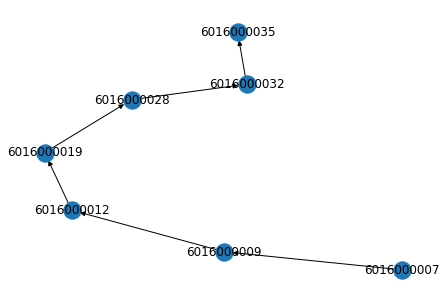

In [12]:
# Create subgraph of diameter patients
diameter_g = nx.DiGraph()

for di_patient in di_patients:
    infected_by = pat_g.nodes[di_patient]['infected_by']
    if not np.isnan(infected_by):
        diameter_g.add_edge(int(infected_by), di_patient)

nx.draw(diameter_g, with_labels=True)
# plt.savefig('graphs/patient-diameter')

## Graph Cycles

In [13]:
list(nx.simple_cycles(pat_g))

[[4100000121, 4100000122],
 [4100000116, 4100000118],
 [1300000010, 1300000011],
 [4100000052, 4100000070],
 [6009000008, 6009000007],
 [4100000006, 4100000007]]

## Graph Degree Distribution

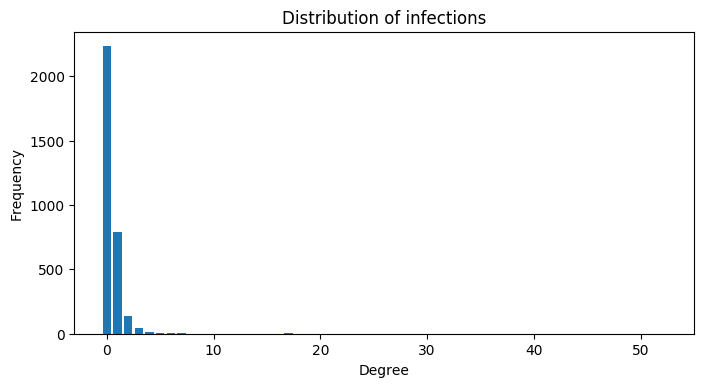

{0: 2235, 1: 793, 5: 7, 2: 140, 3: 45, 17: 2, 6: 2, 4: 15, 27: 1, 22: 1, 7: 5, 11: 1, 9: 1, 18: 1, 25: 1, 52: 1, 21: 1, 15: 1, 10: 1}


In [16]:
def degree_dist(g, max_degree=np.inf, title='Degree Distribution'):
    """
    Plot degree distribution of graph g. Setting a max_degree for the distribution
    bins all degrees higher than max_degree into a single group labelled with 
    max_degree.
    """
    degree_counts = dict()
    for degree in g.degree(g.nodes):
        if degree[1] > max_degree:
            degree_counts[max_degree] = degree_counts.get(max_degree, 0) + 1
            continue
        
        degree_counts[degree[1]] = degree_counts.get(degree[1], 0) + 1

    plt.figure(figsize=(8, 4), dpi= 100)
    plt.bar(degree_counts.keys(), degree_counts.values())
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title(title)
    # plt.savefig('graphs/' + title.replace(' ', '-'))
    plt.show()
    
    return degree_counts

pat_dist = degree_dist(pat_g, title='Distribution of infections')
print(pat_dist)

Power law distribution!!!

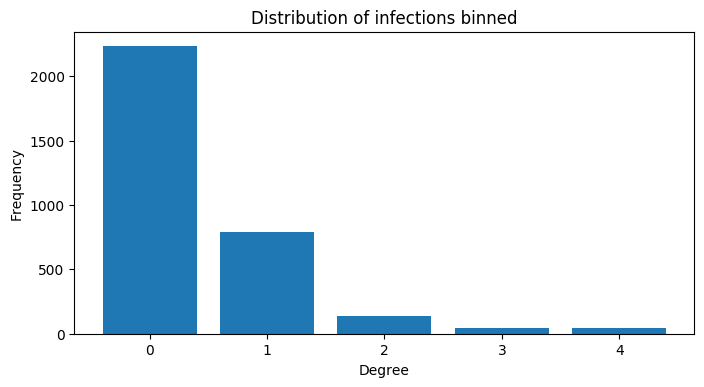

{0: 2235, 1: 793, 4: 41, 2: 140, 3: 45}

In [17]:
# set max_degree to bin higher degrees together
degree_dist(pat_g, max_degree=4, title='Distribution of infections binned')

## Infectious Patients

In [18]:
def find_large_nodes(g, min_degree):
    """
    Find all nodes with degree larger than min_degree.
    """
    nodes = []
    for degree in g.out_degree(g.nodes):
        if degree[1] >= min_degree:
            nodes.append(degree)
            
    return nodes
        
find_large_nodes(pat_g, 15)

[(1200000031, 17),
 (4100000008, 27),
 (4100000006, 21),
 (1000000125, 18),
 (2000000167, 24),
 (2000000205, 51),
 (2000000309, 21),
 (2000000476, 15),
 (2000000508, 17)]

## Graph Clustering Coefficient

In [19]:
np.mean(list(nx.clustering(pat_g).values()))

0.0

# Patient Route Graph

In [20]:
def grow_route_graph(pr):
    pr = pr.sort_values('date')
    cur_date = pr.iloc[0]['date'] # start date
    g = nx.DiGraph()
    patient_tracker = {}
    
    for idx, route in pr.iterrows():
        # yield graph back to caller when moving to next time step
        if route['date'] > cur_date:
            cur_date = route['date']
            yield g
        
        # build g
        if route['city'] not in g:
            g.add_node(route['city'], pos=(route['latitude'], route['longitude']))
            
        # check if we recorded a location for this patient already
        # if we have create edge and update their location
        prev_loc = patient_tracker.get(route['patient_id'])
        if prev_loc:
            if g.has_edge(prev_loc, route['city']):
                g[prev_loc][route['city']]['weight'] += 1
            else:
                g.add_edge(prev_loc, route['city'], weight=1)
        patient_tracker[route['patient_id']] = route['city']

# SIMULATE GROWTH AND TRACK METRICS
city_growth = []
route_growth = []
for route_g in grow_route_graph(pr.copy()):
    city_growth.append(len(route_g)) # track nodes
    route_growth.append(route_g.size()) # track edges

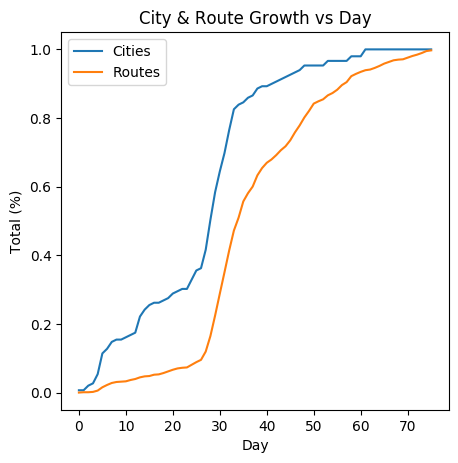

In [21]:
# normalize metrics
city_growth_norm = np.array(city_growth) / len(route_g)
route_growth_norm = np.array(route_growth) / route_g.size()

plt.figure(figsize=(5, 5), dpi= 100)
plt.plot(range(len(city_growth)), city_growth_norm, label='Cities')
plt.plot(range(len(route_growth)), route_growth_norm, label='Routes')
plt.xlabel('Day')
plt.ylabel('Total (%)')
plt.title('City & Route Growth vs Day')
plt.legend(loc='best')
# plt.savefig('graphs/city-route-growth')
plt.show()

## Edge with highest number of recorded routes

In [22]:
# get route that has had the most patients travel
max_edge = (None, None, {'weight': -1})
for edge in route_g.edges(data=True):
    if edge[2]['weight'] > max_edge[2]['weight']:
        max_edge = edge
        
print(max_edge)

('Cheonan-si', 'Cheonan-si', {'weight': 338})


## Edge with highest number of recorded routes (between diff cities)

In [23]:
# get route between two *different* cities with most patients
max_edge = (None, None, {'weight': -1})
for edge in route_g.edges(data=True):
    if edge[2]['weight'] > max_edge[2]['weight'] and edge[0] != edge[1]:
        max_edge = edge

print(max_edge)

('Asan-si', 'Cheonan-si', {'weight': 23})


## Graph Subset Display

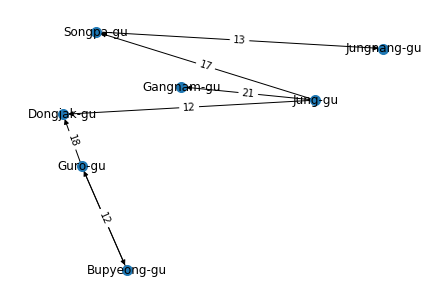

In [24]:
def filter_g_edges(g, min_weight):
    """
    Filter graph by edge weights, removing nodes with degree = 0.
    """
    # remove edges with small weights and same start / end node
    remove_e = []
    for edge in g.edges(data=True):
        if edge[2]['weight'] <= 10:
            remove_e.append(edge)
        elif edge[0] == edge[1]:
            remove_e.append(edge)
    g.remove_edges_from(remove_e)

    # remove nodes with degree zero
    remove_n = []
    for node in g.degree:
        if node[1] == 0:
            remove_n.append(node[0])
    g.remove_nodes_from(remove_n)
    
    return g


def filter_g_location(g, lat, long):
    """
    Filter graph by latitude and longitude values.
    """
    remove_n = []
    for node in g.nodes(data=True):
        pos = node[1]['pos']
        if not (lat[0] < pos[0] < lat[1]) or not (long[0] < pos[1] < long[1]):
            remove_n.append(node[0])
            
    g.remove_nodes_from(remove_n)
    return g


def draw_route_g(g, with_labels=True, node_size=100):
    """
    Draw route graph positioning nodes by lat and long values.
    """
    pos = {
        city:(lat, long) for (city, (lat, long)) in nx.get_node_attributes(filter_route_g, 'pos').items()
    }
    edge_labels = nx.get_edge_attributes(g,'weight')
    
    plt.figure()
    nx.draw(filter_route_g, pos, with_labels=with_labels, node_size=node_size)
    nx.draw_networkx_edge_labels(filter_route_g, pos, edge_labels=edge_labels)

filter_route_g = route_g.copy()
filter_route_g = filter_g_location(filter_route_g, (37, 38), (126, 128))
filter_route_g = filter_g_edges(filter_route_g, 10)
draw_route_g(filter_route_g)
# plt.savefig('graphs/city-infection-graph')

## Graph Diameter

In [25]:
diameter_calc(route_g)

(9, ('Yeongdong-gun', 'Uljin-gun'))

## Graph degree distribution

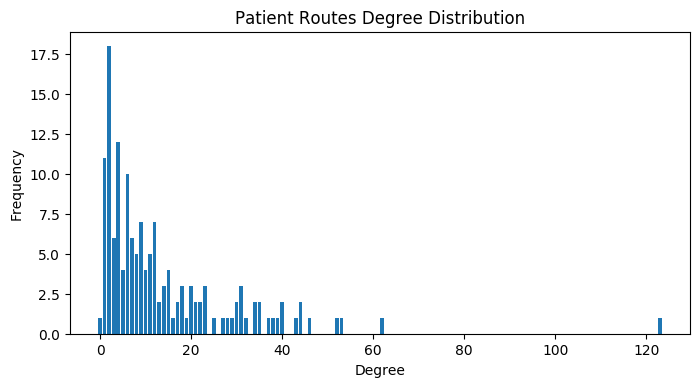

In [26]:
route_dist = degree_dist(route_g, title='Patient Routes Degree Distribution')

not power law

## Graph Clustering Coefficient

In [27]:
np.mean(list(nx.clustering(route_g).values()))

0.3133783087720608

## Cities with high degrees

In [28]:
find_large_nodes(route_g, 20)

[('Gangnam-gu', 28),
 ('Jung-gu', 67),
 ('Namdong-gu', 23),
 ('Jongno-gu', 22),
 ('Dong-gu', 25),
 ('Nam-gu', 24),
 ('Seo-gu', 22),
 ('Guro-gu', 27),
 ('Gangseo-gu', 23)]